In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from time import time
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')
import sys
sys.path.append('..')

In [3]:
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, SparseFirstDiffConvex
from osd.utilities import progress
import cvxpy as cvx

# Convex example, $K=3$

In [4]:
np.random.seed(42)
t = np.linspace(0, 1000, 3000)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
y = signal1 + signal2 + 0.25 * np.random.randn(len(signal1))

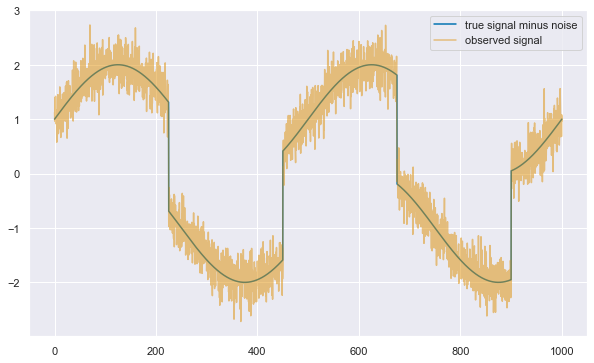

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1 + signal2, label='true signal minus noise')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

# Solve problem all at once with CVXPY

In [6]:
problem = Problem(data=y, components=[GaussNoise, SmoothSecondDifference, SparseFirstDiffConvex(vmin=-1, vmax=1)])
problem.weights.value = np.array([1., 1e7, 1e1])
problem.decompose(solver='MOSEK', verbose=False)
problem.problem.value

261.29221536690466

prob value: 2.61e+02


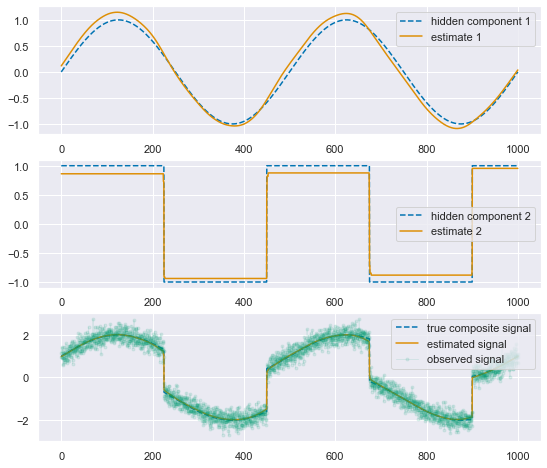

In [7]:
print('prob value: {:.2e}'.format(problem.problem.value))
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

# Simple implementation of ADMM algorithm

Nothing fancy here. Just a quick and dirty implementation of the three proximal operators.

In [8]:
def prox1(v, theta, rho):
    r = rho / (2 * theta + rho)
    return r * v

def prox2(v, theta, rho, A=None, return_A=True):
    if A is None:
        n = len(v)
        M = np.diff(np.eye(n), axis=0, n=2)
        r = 2 * theta / rho
        A = np.linalg.inv(np.eye(n) + r * M.T.dot(M))
    if not return_A:
        return A.dot(v)
    else:
        return A.dot(v), A

def prox3_cvx(v, theta, rho):
    n = len(v)
    M = np.diff(np.eye(n), axis=0, n=1)
    x = cvx.Variable(n)
    cost = theta * cvx.norm1(cvx.diff(x)) + (rho / 2) * cvx.sum_squares(x - v)
    problem = cvx.Problem(cvx.Minimize(cost), [cvx.max(x) <= 1, cvx.min(x) >= -1])
#     problem = cvx.Problem(cvx.Minimize(cost))
    problem.solve(solver='MOSEK')
    return x.value

def calc_obj(y, x2, x3, rho1=1, rho2=1e7, rho3=1e1):
    x1 = y - x2 - x3
    t1 = rho1 * np.sum(np.power(x1, 2))
    t2 = rho2 * np.sum(np.power(np.diff(x2, 2), 2))
    t3 = rho3 * np.sum(np.abs(np.diff(x3, 1)))
    return t1 + t2 + t3

def run_admm(data, num_iter=50, rho=0.5, theta=1e7, verbose=True, prox3=prox3_cvx):
    y = data
    A = None
    u = np.zeros_like(y)
    x1 = y / 3
    x2 = y / 3
    x3 = y / 3
    residuals = []
    obj_vals = []
    ti = time()
    best = {
        'x1': None,
        'x2': None,
        'x3': None,
        'u': None,
        'it': None,
        'obj_val': np.inf
    }
    for it in range(num_iter):
        if verbose:
            td = time() - ti
            progress(it, num_iter, '{:.2f} sec'.format(td))
        # Apply proximal operators
        x1 = prox1(x1 - u, 1, rho)
        x2, A = prox2(x2 - u, theta, rho, A=A, return_A=True)
        x3 = prox3(x3 - u, 1e1, rho)
        # Consensus step
        u += 2 * (np.average([x1, x2, x3], axis=0) - y / 3)
        # mean-square-error
        error = np.sum([x1, x2, x3], axis=0) - y
        mse = np.sum(np.power(error, 2)) / error.size
        residuals.append(mse)
        obj_val = calc_obj(y, x2, x3)
        obj_vals.append(obj_val)
        if obj_val < best['obj_val']:
                best = {
                    'x1': y - x2 - x3,
                    'x2': x2,
                    'x3': x3,
                    'u': u,
                    'it': it,
                    'obj_val': obj_val
                }
    if verbose:
        td = time() - ti
        progress(it + 1, num_iter, '{:.2f} sec\n'.format(td))
    outdict = {
        'x1': best['x1'],
        'x2': best['x2'],
        'x3': best['x3'],
        'u': best['u'],
        'it': best['it'],
        'residuals': residuals,
        'obj_vals': obj_vals
    }
    return outdict

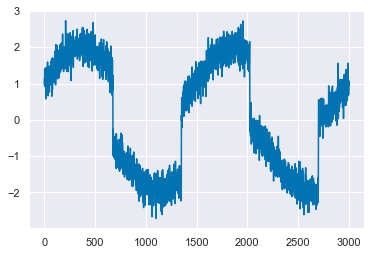

In [50]:
plt.plot(y);

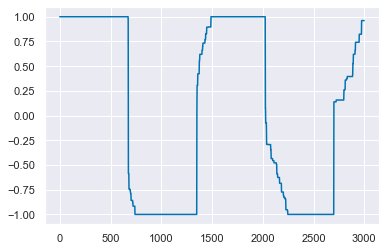

In [51]:
plt.plot(prox3_cvx(y, theta=1, rho=1))

In [16]:
def soft_thresh(x, gamma):
    c1 = x - gamma
    c2 = x + gamma
    out = np.zeros_like(x)
    out[x > gamma] = c1[x > gamma]
    out[x < -gamma] = c2[x < - gamma]
    out[0] = x[0]
    return out

In [8]:
run1 = run_admm(y, num_iter=1000, rho=1e-1)
run2 = run_admm(y, num_iter=1000, rho=1e0)
run3 = run_admm(y, num_iter=1000, rho=1e1)

[============================================================] 100.0% ...264.35 sec
[============================================================] 100.0% ...222.09 sec
[============================================================] 100.0% ...237.24 sec


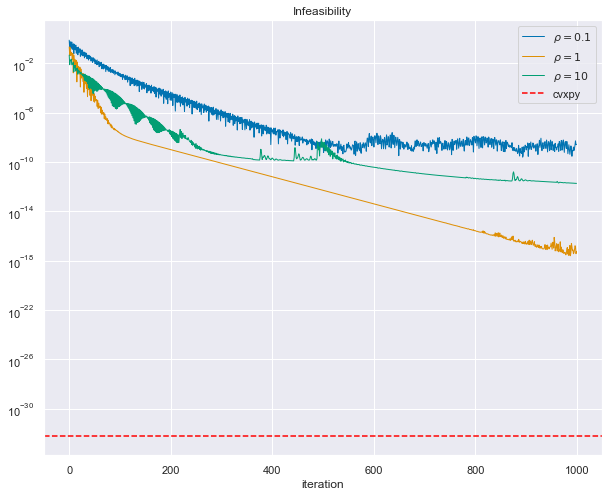

In [27]:
error = np.sum(problem.estimates, axis=0) - y
mse = np.sum(np.power(error, 2)) / error.size
plt.figure(figsize=(10,8))
plt.plot(run1['residuals'], label='$\\rho=0.1$', linewidth=1)
plt.plot(run2['residuals'], label='$\\rho=1$', linewidth=1)
plt.plot(run3['residuals'], label='$\\rho=10$', linewidth=1)
plt.axhline(mse, ls='--', color='red', label='cvxpy')
plt.yscale('log')
plt.legend(loc=1)
plt.title('Infeasibility')
plt.xlabel('iteration');

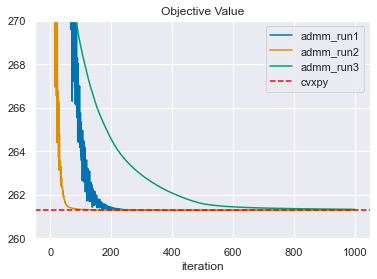

In [42]:
plt.plot(run1['obj_vals'], label='admm_run1')
plt.plot(run2['obj_vals'], label='admm_run2')
plt.plot(run3['obj_vals'], label='admm_run3')
plt.axhline(problem.problem.objective.value, ls='--', color='red', label='cvxpy')
plt.legend()
plt.title('Objective Value')
plt.xlabel('iteration')
plt.ylim(260, 270); 
# plt.yscale('log');

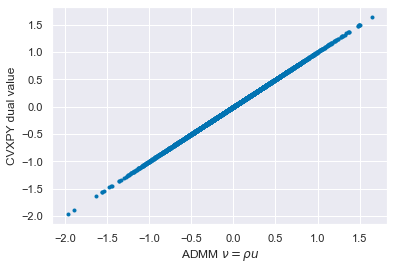

In [41]:
plt.plot(1e0 * run2['u'], problem.problem.constraints[-1].dual_value, ls='none', marker='.')
plt.xlabel('ADMM $\\nu = \\rho u$')
plt.ylabel('CVXPY dual value');

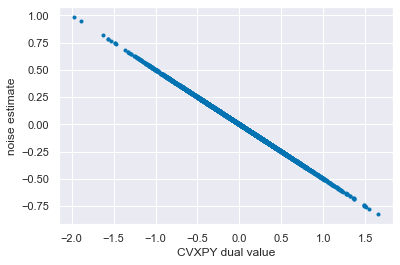

In [12]:
plt.plot(problem.problem.constraints[-1].dual_value, problem.estimates[0], ls='none', marker='.')
plt.ylabel('noise estimate')
plt.xlabel('CVXPY dual value');

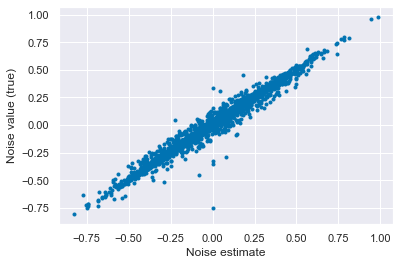

In [13]:
plt.plot(problem.estimates[0], y - signal1 - signal2, ls='none', marker='.')
plt.xlabel('Noise estimate')
plt.ylabel('Noise value (true)');

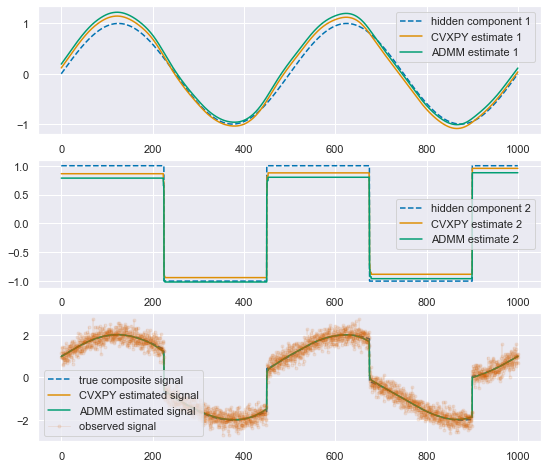

In [30]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='CVXPY estimate 1')
ax[0].plot(t, run2['x2'], label='ADMM estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='CVXPY estimate 2')
ax[1].plot(t, run2['x3'], label='ADMM estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='CVXPY estimated signal');
ax[2].plot(t, run2['x2'] + run2['x3'], label='ADMM estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

# Non-convex model

Replace the heuristic for a sparse first difference with the constraint that $x^3\in\left\{-1,1\right\}^T$. Objective function is calculated using the L1-heuristic to allow for an apples-to-apples comparison to previous results.

In [55]:
def prox3_noncvx(v, theta, rho):
    v1 = np.ones_like(v)
    v2 = -1 * np.ones_like(v)
    d1 = np.abs(v - v1)
    d2 = np.abs(v - v2)
    x = np.ones_like(v1)
    x[d2 < d1] = -1
    return x

In [56]:
run_noncvx = run_admm(y, num_iter=100, rho=5, prox3=prox3_noncvx)

[============================================================] 100.0% ...1.65 sec


In [57]:
run_noncvx['it']

63

In [41]:
mse

2.1234407474568873e-18

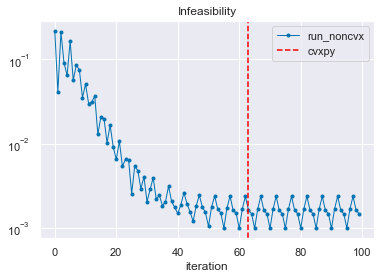

In [60]:
error = np.sum(problem.estimates, axis=0) - y
mse = np.sum(np.power(error, 2)) / error.size
r = np.linalg.norm(
    np.average(problem.estimates, axis=0) - y / 3
)
# plt.plot(run1['residuals'], label='run1')
# plt.plot(run2['residuals'], label='run2')
# plt.plot(run3['residuals'], label='run3')
plt.plot(run_noncvx['residuals'], label='run_noncvx', linewidth=1, marker='.')
plt.axhline(mse, ls='--', color='red', label='cvxpy')
plt.axvline(run_noncvx['it'], ls='--', color='red')
plt.yscale('log')
plt.legend()
plt.title('Infeasibility')
plt.xlabel('iteration');

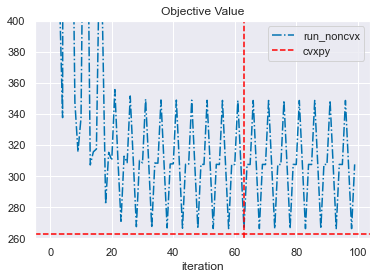

In [61]:
# plt.plot(run1['obj_vals'], label='run1')
# plt.plot(run2['obj_vals'], label='run2')
# plt.plot(run3['obj_vals'], label='run3')
plt.plot(run_noncvx['obj_vals'], label='run_noncvx', ls='-.')
plt.axhline(problem.problem.objective.value, ls='--', color='red', label='cvxpy')
plt.axvline(run_noncvx['it'], ls='--', color='red')
plt.legend()
plt.title('Objective Value')
plt.xlabel('iteration')
plt.ylim(260, 400);

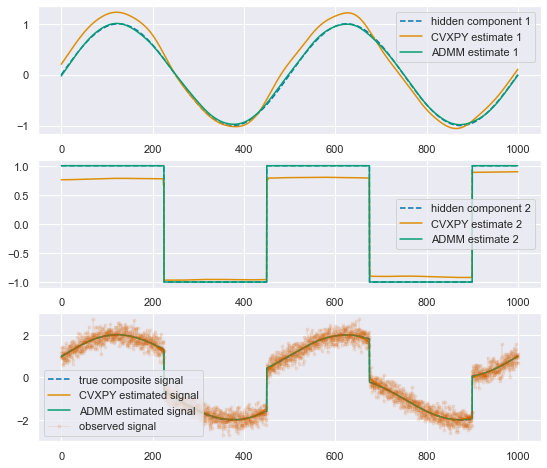

In [62]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='CVXPY estimate 1')
ax[0].plot(t, run_noncvx['x2'], label='ADMM estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='CVXPY estimate 2')
ax[1].plot(t, run_noncvx['x3'], label='ADMM estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='CVXPY estimated signal');
ax[2].plot(t, run_noncvx['x2'] + run_noncvx['x3'], label='ADMM estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

In [299]:
foo = np.random.randn(20)
# foo = np.r_[[0, 0, 0], foo, [0, 0, 0]]
pfoo = prox2(foo, 1, 1, return_A=False)

In [ ]:
def pad_window(w, n):
    m = len(w)
    m_is_even = m % 2 == 0
    m_is_odd = n % 2 == 0
    

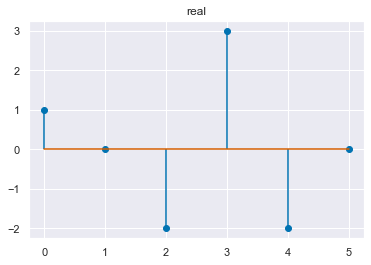

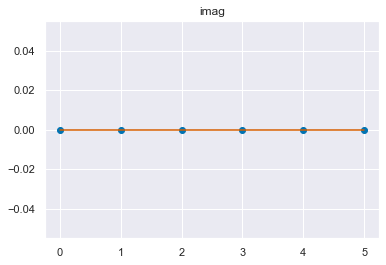

In [334]:
out = np.fft.fft([0, 0, 1, -1, 1, 0])
plt.stem(np.real(out))
plt.title('real')
plt.figure()
plt.title('imag')
plt.stem(np.imag(out));

In [300]:
# g = np.fft.fft([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1], n=len(foo))
g = np.fft.fft([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1], n=len(foo))
a = g ** 2
u = np.fft.fft(foo, n=len(foo))
c1 = np.isclose(a, 0)
c2 = np.logical_and(np.isclose(np.imag(a), 0), ~c1)
c3 = np.logical_and(~c1, ~c2)
z_real = np.zeros(len(foo))
z_imag = np.zeros(len(foo))

z_real[c1] = np.real(u[c1])
z_imag[c1] = np.imag(u[c1])

z_real[c2] = 0.5 * np.real(u[c2]) / (np.real(a[c2]) + 0.5)
z_imag[c2] = 0.5 * np.imag(u[c2]) / (np.real(a[c2]) + 0.5)

z_real[c3] = (0.5) * (np.imag(a[c3])*np.imag(u[c3]) +np.real(a[c3])*np.real(u[c3]) + 0.5*np.real(u[c3])) / \
    ((np.real(a[c3]) + 0.5)**2 + np.real(g[c3]) * np.imag(a[c3]))
z_imag[c3] = ((np.real(a[c3]) + 0.5)/ np.imag(a[c3])) * z_real[c3] - 0.5 * np.real(u[c3]) / np.imag(a[c3])

z = z_real + z_imag *1j

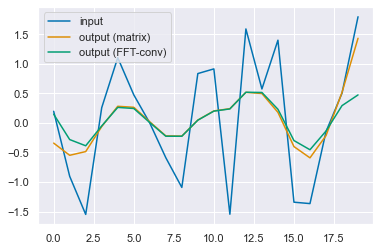

In [301]:
plt.plot(foo, label='input')
plt.plot(pfoo, label='output (matrix)')
plt.plot(np.real(np.fft.ifft(z)), label='output (FFT-conv)')
plt.legend()

In [313]:
import scipy.fft as fft

In [311]:
np.linalg.norm(foo)

4.712938973740451

In [314]:
np.linalg.norm(fft.dct(foo)) / np.sqrt(len(foo))

6.674252565617037

In [278]:
np.fft.ifft(z)

array([ 0.00568063+0.00000000e+00j, -0.0934433 +4.27008856e-18j,
       -0.26417158+1.08339254e-17j, -0.48940297+3.31935463e-18j,
       -0.61995046+3.26625663e-18j, -0.69277705+2.61645035e-17j,
       -0.41985482+2.24691366e-17j, -0.24295905+1.55683321e-18j,
        0.04429019+5.83136742e-18j, -0.01099426+4.85267816e-18j,
       -0.13213474-6.72556993e-18j, -0.20201649-1.64957978e-17j,
       -0.14329089-1.08213291e-17j, -0.09146801+8.62585980e-18j,
       -0.25443192-7.82151030e-18j, -0.08506701-1.13956567e-17j,
       -0.15294604-2.48171402e-21j, -0.34662558-9.02016657e-18j,
       -0.30917741-2.15908916e-17j, -0.11387138-2.11819843e-17j,
       -0.21704482-7.62549873e-18j, -0.17990284+1.66338702e-19j,
        0.07211841-8.68741210e-18j,  0.12685893+7.68422510e-18j,
        0.1047568 +2.08740073e-17j,  0.06282063+1.45372365e-18j])

In [242]:
np.fft.fft([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1], n=len(foo))

array([ 0.        +0.j,  0.09788697+0.j, -0.38196601+0.j,  0.8244295 +0.j,
       -1.38196601+0.j,  2.        +0.j, -2.61803399+0.j,  3.1755705 +0.j,
       -3.61803399+0.j,  3.90211303+0.j, -4.        +0.j,  3.90211303+0.j,
       -3.61803399+0.j,  3.1755705 +0.j, -2.61803399+0.j,  2.        +0.j,
       -1.38196601+0.j,  0.8244295 +0.j, -0.38196601+0.j,  0.09788697+0.j])

In [236]:
np.fft.fft([1, -2, 1], n=len(foo))

array([ 0.00000000e+00+0.00000000e+00j, -9.30960382e-02+3.02487365e-02j,
       -3.09016994e-01+2.24513988e-01j, -4.84587499e-01+6.66977472e-01j,
       -4.27050983e-01+1.31432778e+00j,  1.11022302e-16+2.00000000e+00j,
        8.09016994e-01+2.48989828e+00j,  1.86655351e+00+2.56909051e+00j,
        2.92705098e+00+2.12662702e+00j,  3.71113003e+00+1.20581924e+00j,
        4.00000000e+00-2.22044605e-16j,  3.71113003e+00-1.20581924e+00j,
        2.92705098e+00-2.12662702e+00j,  1.86655351e+00-2.56909051e+00j,
        8.09016994e-01-2.48989828e+00j,  2.22044605e-16-2.00000000e+00j,
       -4.27050983e-01-1.31432778e+00j, -4.84587499e-01-6.66977472e-01j,
       -3.09016994e-01-2.24513988e-01j, -9.30960382e-02-3.02487365e-02j])

In [249]:
np.fft.fft([0, 0, 0, 0, 1, -2, 1], n=len(foo))

array([ 0.        +0.j        ,  0.        +0.09788697j,
        0.38196601+0.j        ,  0.        -0.8244295j ,
       -1.38196601+0.j        ,  0.        +2.j        ,
        2.61803399+0.j        ,  0.        -3.1755705j ,
       -3.61803399+0.j        ,  0.        +3.90211303j,
        4.        +0.j        ,  0.        -3.90211303j,
       -3.61803399+0.j        ,  0.        +3.1755705j ,
        2.61803399+0.j        ,  0.        -2.j        ,
       -1.38196601+0.j        ,  0.        +0.8244295j ,
        0.38196601+0.j        ,  0.        -0.09788697j])